In [1088]:
import numpy as np
import matplotlib.pyplot as plt

################Paramètres#########################

gamma = 1.4

###############Conditions initiales (Riemann) test 1###################
ul = np.array([1, 0, 1])  # Gauche
ur = np.array([0.125, 0, 0.1])  # Droite
T = 0.20
###############Conditions initiales (Riemann) test 2##################
#ul = [1, 0, 0.01]  # Conditions à gauche
#ur = [1, 0, 100]  # Conditions à droite
#T = 0.030

######################################################
J = 1000
dx = 2/ J  # Domaine [-1,1]
xx = np.linspace(-1+dx/2, 1-dx/2, J)  # Centres des mailles
x= np.zeros(J + 2)  # Maillage avec points fictifs
x[1:-1] = xx
x[0], x[-1] = -1, 1  # Extrapolation des bords


In [1090]:
def initial_conditions(x):
    """Initialise les conditions pour rho, rho_u, rho_E selon ul et ur."""
    J = len(x)
    rho = np.zeros(J)
    rho_u = np.zeros(J)
    rho_E = np.zeros(J)
    for i in range(J):
        if x[i] < 0:  # Zone de gauche
            rho[i] = ul[0]
            rho_u[i] = ul[0] * ul[1]
            rho_E[i] = 0.5 * rho[i] * (ul[1]**2) + ul[2] / (gamma - 1)
        else:  # Zone de droite
            rho[i] = ur[0]
            rho_u[i] = ur[0] * ur[1]
            rho_E[i] = 0.5 * rho[i] * (ur[1]**2) + ur[2] / (gamma - 1)
    return rho, rho_u, rho_E

In [1091]:
def flux(rho, rho_u, rho_E, gamma):
    """Calcule le flux en fonction des variables rho, rho_u, rho_E."""
    u = rho_u / rho
    p = (rho_E - 0.5 * rho * (u**2)) * (gamma - 1)
    f1 = rho * u
    f2 = rho * (u**2) + p
    f3 = (rho_E + p) * u
    return f1, f2, f3


In [1092]:
import numpy as np

def Rusanov_solver(gamma, J, T):
    """Méthode de Rusanov pour résoudre les équations de conservation."""
    
    rho, rho_u, rho_E = initial_conditions(x)  # Initialisation

    # Initialisation des flux
    fG_rho = np.zeros(J)
    fD_rho = np.zeros(J)
    fG_rho_u = np.zeros(J)
    fD_rho_u = np.zeros(J)
    fG_rho_E = np.zeros(J)
    fD_rho_E = np.zeros(J)

    # Temps initial
    t = 0

    while t < T:
        ##########Calcul des paramètres physiques#############
        u = rho_u / rho
        p = (rho_E - 0.5 * rho * (u**2)) * (gamma - 1)
        c = np.sqrt(gamma * p /rho)

        # Condition CFL
        S = np.max([np.abs(u - c), np.abs(u), np.abs(u + c)]) 
        dt = min(dx / (2 * S), T - t)

        ############Calcul des flux################
        f_rho, f_rho_u, f_rho_E = flux(rho, rho_u, rho_E, gamma)
        
        ##### Boucle sur les cellules internes#######
        for j in range(1, J+1):  
            fG_rho[j-1] = 0.5 * (f_rho[j] + f_rho[j-1]) - S / 2 * (rho[j] - rho[j-1])
            fD_rho[j-1] = 0.5 * (f_rho[j] + f_rho[j+1]) - S / 2 * (rho[j+1] - rho[j])
            fG_rho_u[j-1] = 0.5 * (f_rho_u[j] + f_rho_u[j-1]) - S / 2 * (rho_u[j] - rho_u[j-1])
            fD_rho_u[j-1] = 0.5 * (f_rho_u[j] + f_rho_u[j+1]) - S / 2 * (rho_u[j+1] - rho_u[j])
            fG_rho_E[j-1] = 0.5 * (f_rho_E[j] + f_rho_E[j-1]) - S / 2 * (rho_E[j] - rho_E[j-1])
            fD_rho_E[j-1] = 0.5 * (f_rho_E[j] + f_rho_E[j+1]) - S / 2 * (rho_E[j+1] - rho_E[j])

        #######Mise à jour des solutions#############
        rho[1:-1] -= dt / dx * (fD_rho - fG_rho)
        rho_u[1:-1] -= dt / dx * (fD_rho_u - fG_rho_u)
        rho_E[1:-1] -= dt / dx * (fD_rho_E - fG_rho_E)

        #############Conditions aux limites (Neumann)######################
        rho[0], rho[-1] = rho[1], rho[-2]
        rho_u[0], rho_u[-1] = rho_u[1], rho_u[-2]
        rho_E[0], rho_E[-1] = rho_E[1], rho_E[-2]

        ##############Mise à jour du temps#################
        t += dt

    return rho, rho_u, rho_E


In [1096]:
###########Exécution de la méthode de Rusanov###############
rho, rho_u, rho_E = Rusanov_solver(gamma, J, T)
u = rho_u / rho
p = (rho_E - 0.5 * rho * (u**2)) * (gamma - 1)
u0 = initial_conditions(x)

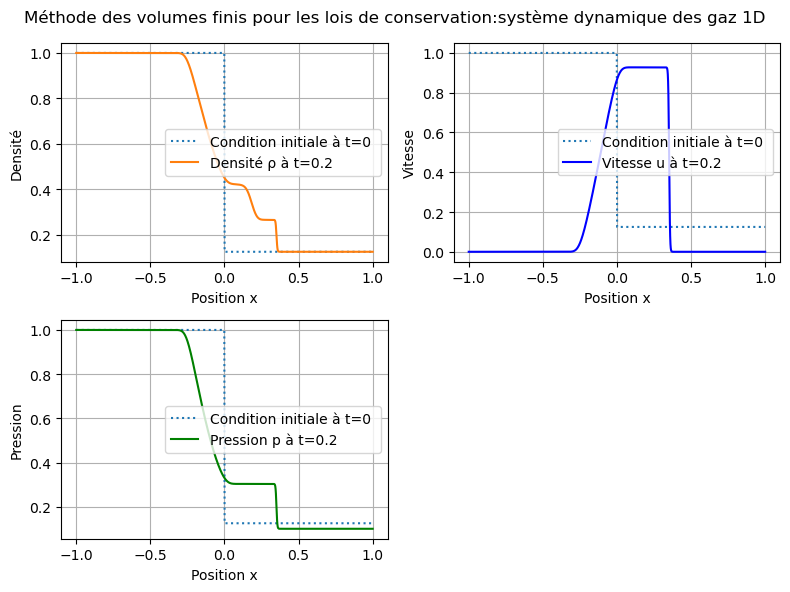

In [1097]:
##############Affichage des résultats###################
plt.figure(figsize=(8,6))
plt.suptitle("Méthode des volumes finis pour les lois de conservation:système dynamique des gaz 1D")

plt.subplot(221)
plt.plot(x,u0[0], label=f'Condition initiale à t=0 ', linestyle=":")
plt.plot(x, rho, '-',  label=f'Densité ρ à t={T}')
plt.ylabel("Densité"); plt.xlabel("Position x")
plt.legend()
plt.grid()

plt.subplot(222)
plt.plot(x,u0[0], label=f'Condition initiale à t=0 ', linestyle=":")
plt.plot(x, u, 'b' , label=f'Vitesse u à t={T}')
plt.ylabel("Vitesse"); plt.xlabel("Position x")
plt.legend()
plt.grid()

plt.subplot(223)
plt.plot(x,u0[0], label=f'Condition initiale à t=0 ', linestyle=":")
plt.plot(x, p, 'g',label=f'Pression p à t={T}')
plt.ylabel("Pression"); plt.xlabel("Position x")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
